In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
seed = 42
torch.manual_seed(seed)
import random
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True  # if using GPU
torch.backends.cudnn.benchmark = False  # if using GPU, set this to False to ensure reproducibility
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna.samplers import TPESampler
from torchvision import transforms
project_root = 'E:\Homework\FYP'

In [6]:
class TrussDataset(Dataset):
    def __init__(self, health_path, damage_path, num_steps=2001, num_nodes=32, transform=None):
        self.X = []
        self.y = []
        self.num_steps = num_steps
        self.num_nodes = num_nodes
        self.transform = transform

        # 加载健康数据
        self.load_data(health_path, label=0)
        # 加载损坏数据
        self.load_data(damage_path, label=1)

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def load_data(self, folder_path, label):
        # 遍历文件夹中的csv文件
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            data = pd.read_csv(file_path)

            # 提取每个节点的数据
            for node_id in range(1, self.num_nodes + 1):
                if node_id in [2, 3, 20, 29, 32]:  # 排除特定节点
                    continue
                node_data = data[data['Node ID'] == node_id]
                acc_x = node_data[' Accleration_x'].values
                acc_y = node_data[' Accleration_y'].values
                acc_z = node_data[' Accleration_z'].values

                # 将 x, y, z 加速度数据合并为 (steps, features) 的格式
                node_sequence = np.stack([acc_x, acc_y, acc_z], axis=-1)

                # 确保每个节点的数据长度一致
                if node_sequence.shape[0] == self.num_steps:
                    self.X.append(node_sequence)
                    self.y.append(label)
                else:
                    print(file_name, node_id, node_data)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx]
        labels = self.y[idx]

        if self.transform:
            features = self.transform(features)

        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        return features, labels

    def train_test_val_splits(self, train_size, test_size):
        train_indices, temp_indices, _, _ = train_test_split(
            range(len(self)), self.y, train_size=train_size, random_state=42)

        train = Subset(self, train_indices)
        temp = Subset(self, temp_indices)

        # 使用剩余的数据划分验证和测试集
        targets_temp = [self.y[i] for i in temp_indices]
        test_size = test_size / (1 - train_size)
        val_indices, test_indices, _, _ = train_test_split(
            range(len(temp)), targets_temp, test_size=test_size, random_state=42)

        val = Subset(temp, val_indices)
        test = Subset(temp, test_indices)

        print("Order of output splits: Train, Validation, Test")
        return train, val, test

class Flatten:
    def __call__(self, sample):
        reshaped_sample = sample.reshape(sample.shape[0] * sample.shape[1])
        return reshaped_sample


class Standardize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        return (sample - self.mean) / self.std


# 数据加载器生成函数
def generate_loaders(train_split, val_split, test_split, batch_size):
    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=batch_size)
    test_loader = DataLoader(test_split, batch_size=batch_size)
    return train_loader, val_loader, test_loader


dataset = TrussDataset(health_path='E:\Homework\FYP\Health_Truss_data_v3',
                        damage_path='E:\Homework\FYP\Damage_Truss_data_v3',
                        transform=None)

In [7]:
splits = dataset.train_test_val_splits(train_size=0.6, test_size=0.2)
train_loader, val_loader, test_loader = generate_loaders(splits[0], splits[1], splits[2], batch_size=64)

Order of output splits: Train, Validation, Test


In [8]:
features, labels = next(iter(train_loader))

In [9]:
features.shape

torch.Size([64, 2001, 3])

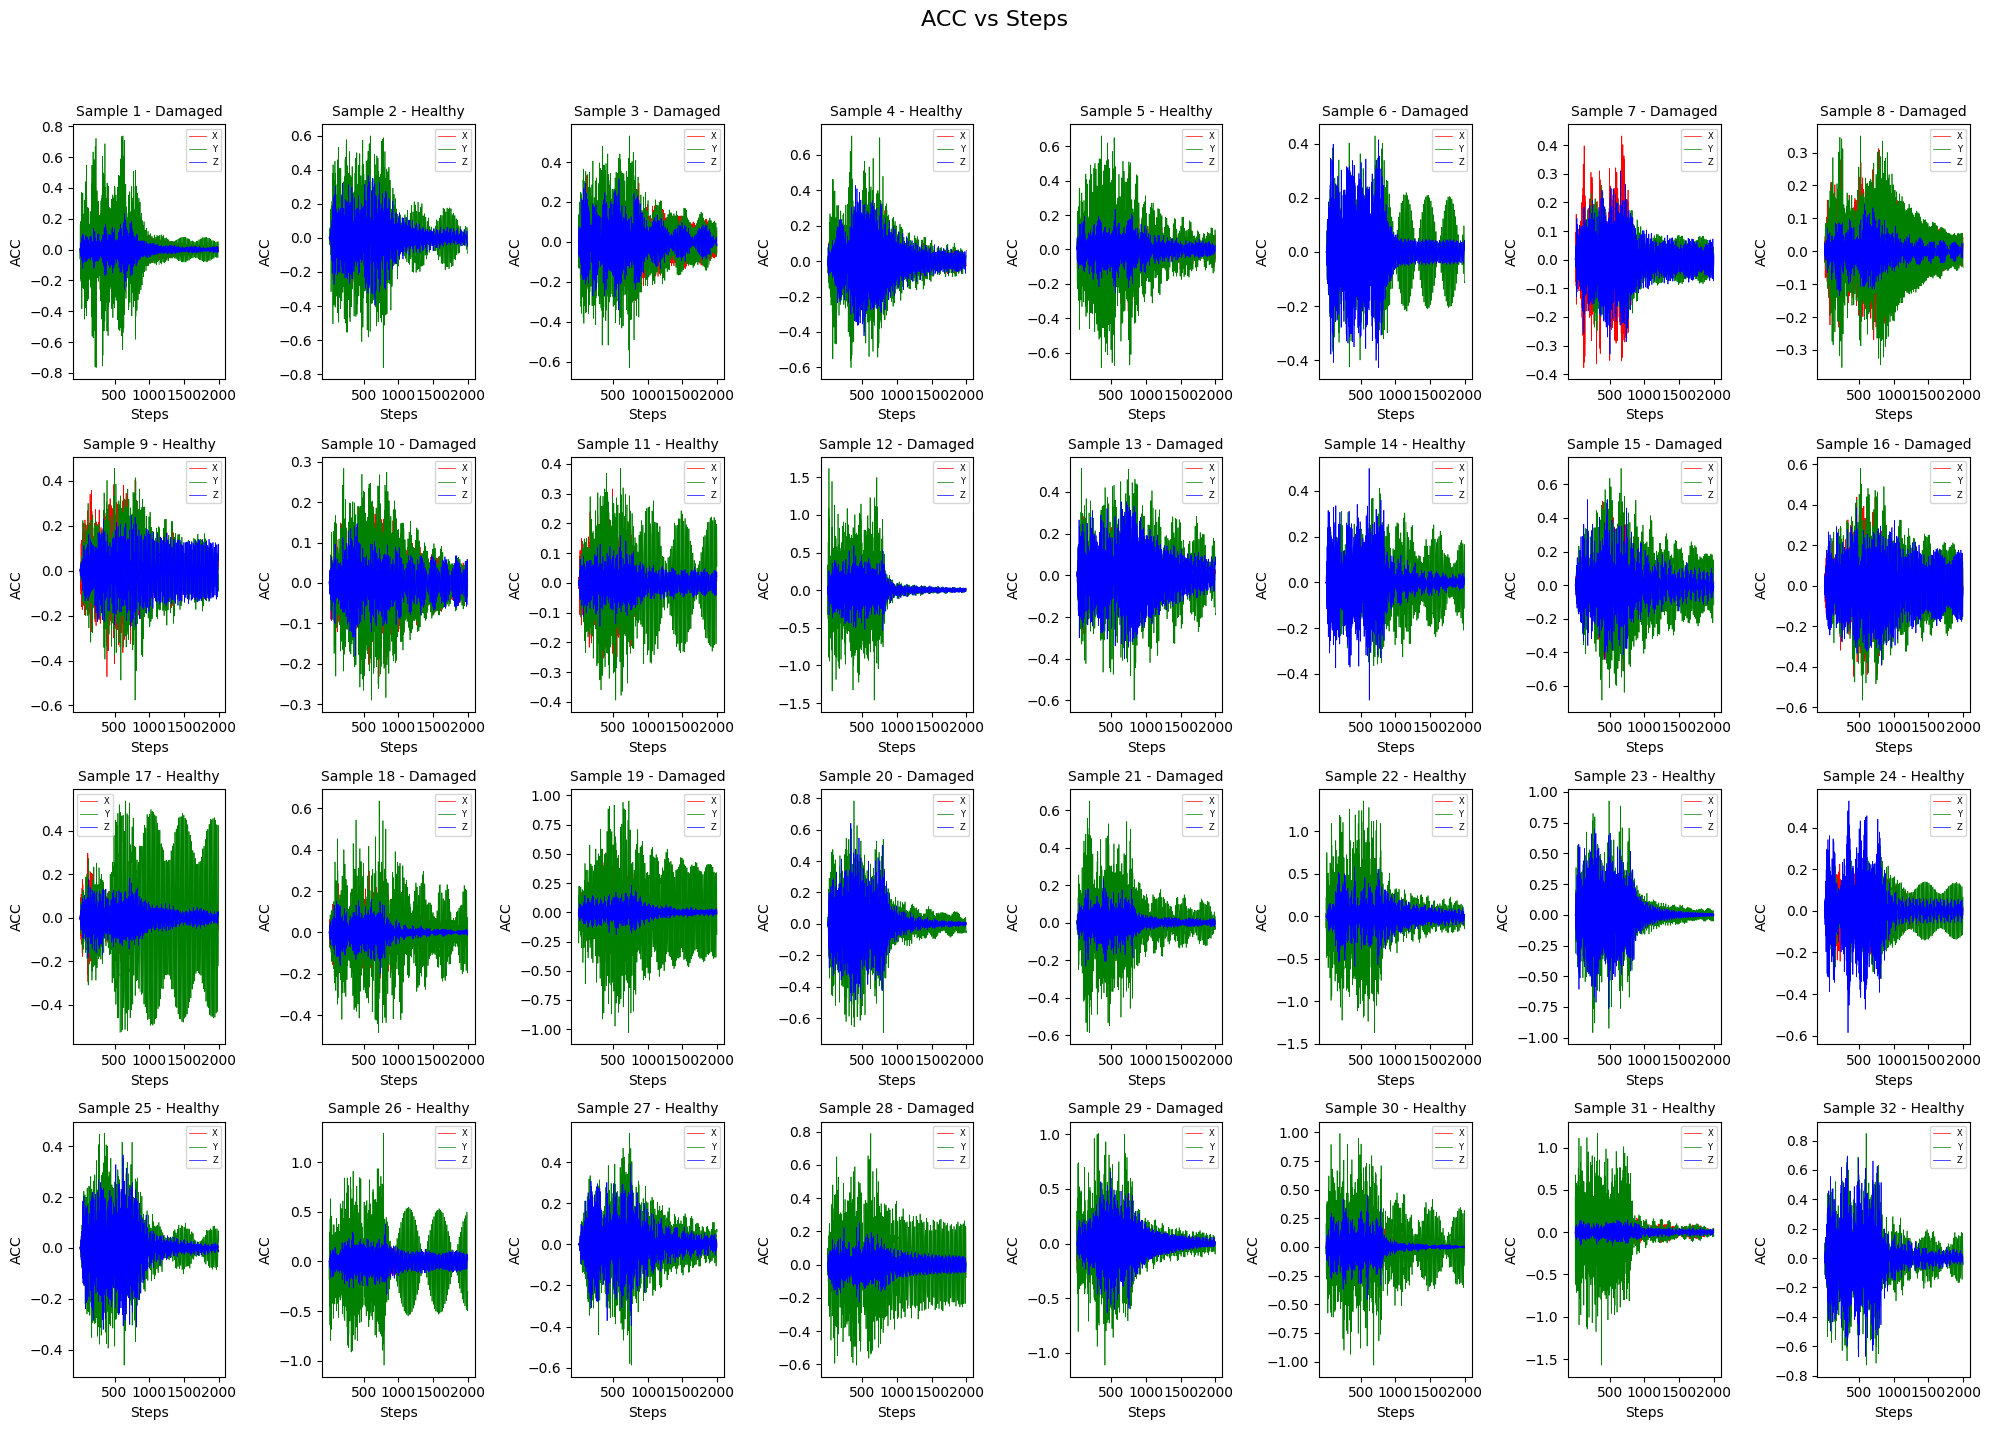

In [10]:
# Set up the grid for plotting
fig, axes = plt.subplots(4, 8, figsize=(20, 15))  # 32 subplots (4x8 grid)
fig.suptitle("ACC vs Steps", fontsize=16)

# Number of steps (time points) in each sample
num_steps = features.shape[1]

# Plot each sample in the batch
for i in range(32):
    feature = features[i]  # Get the i-th sample in the batch
    label = labels[i].item()  # Get the corresponding label (0 or 1)
    ax = axes[i // 8, i % 8]  # Position on the grid (4x8 layout)
    
    # Plot x, y, z acceleration over time steps
    ax.plot(range(num_steps), feature[:, 0].numpy(), label='X', color='r', linewidth=0.5)
    ax.plot(range(num_steps), feature[:, 1].numpy(), label='Y', color='g', linewidth=0.5)
    ax.plot(range(num_steps), feature[:, 2].numpy(), label='Z', color='b', linewidth=0.5)
    
    # Add sample number and label in the title
    ax.set_title(f'Sample {i+1} - {"Healthy" if label == 0 else "Damaged"}', fontsize=10)
    ax.set_xticks([500, 1000, 1500, 2000])  # Adjust based on your time steps
    ax.set_xlabel('Steps')
    ax.set_ylabel('ACC')
    ax.legend(fontsize=6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for spacing
#plt.show()

In [11]:
def plot_eval(epochs,train_loader,train_loss,val_loss,train_accuracy, val_accuracy):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range(epochs*len(train_loader))),train_loss, label="train")
  plt.plot(list(range(0, epochs*len(train_loader),len(train_loader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(epochs)), train_accuracy, label="train")
  plt.plot(list(range(epochs)),val_accuracy, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [12]:
def plot_estop_eval(stop_e, train_loader,train_loss,val_loss,train_accuracy, val_accuracy):

  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range((stop_e+1)*len(train_loader))),train_loss, label="train")
  plt.plot(list(range(0, (stop_e+1)*len(train_loader),len(train_loader))), val_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(stop_e+1)), train_accuracy, label="train")
  plt.plot(list(range(stop_e+1)),val_accuracy, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()


In [13]:
def loss_func(logits, y):
    return nn.CrossEntropyLoss()(logits, y)

In [14]:
def train_epoch(model, optimizer, loss_func, dataloader, device):
  model.train()
  train_correct = 0
  train_loss = []
  for x_train_batch, y_train_batch in dataloader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch.cpu())
    train_loss.append(loss.item()/len(x_train_batch))
  train_accuracy = train_correct/len(dataloader.dataset)
  return train_loss, train_accuracy

def val_epoch(model, loss_func, dataloader, device):
  model.eval()
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch.cpu())
  val_loss = tmp_val_loss/len(dataloader.dataset) # compute the average loss
  val_accuracy = val_correct/len(dataloader.dataset)
  return val_loss, val_accuracy

In [15]:
def train_and_validate(model, optimizer, loss_func, train_loader, val_loader, save_path, epochs=40):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model

    model.to(device)
    min_val_loss = np.Inf

    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_loader, device)

        train_loss.extend(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Train acc.: {epoch_train_accuracy:.4f}, Validation acc.: {epoch_val_accuracy:.4f}')
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy
            }, save_path)

    print('Training finished.')
    return train_loss, train_accuracy, val_loss, val_accuracy

In [16]:
def test_model(model, test_loader, loss_func, title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct_predictions = 0
    total_samples = len(test_loader.dataset)

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # print(outputs.shape)
            loss = loss_func(outputs, labels.long())
            test_loss += loss.item()
            _, predicted = outputs.max(1) # gets predicted class, discards max values obtained across 13 classes
            # print(outputs.max(1))
            correct_predictions += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    unique_labels = sorted(set(all_labels + all_preds))

    fig, ax = plt.subplots(figsize=(8,8))
    cm  = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Adjust display_labels as needed
    disp.plot(ax=ax)
    plt.title(title)
    plt.show()

    avg_loss = test_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [18]:
basic_lstm = LSTM(input_size=3, hidden_size=64, num_layers=1, output_size=2)
print(basic_lstm)

LSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
%%time
optimizer = torch.optim.Adam(basic_lstm.parameters(), lr=0.01,)
save_path = project_root+ 'best_basicLSTM.pth'

# perform training, save the model at the best epoch val_loss
train_loss,train_accuracy, val_loss, val_accuracy=train_and_validate(basic_lstm,optimizer, loss_func,
                                                                     train_loader, val_loader , save_path, epochs=100)

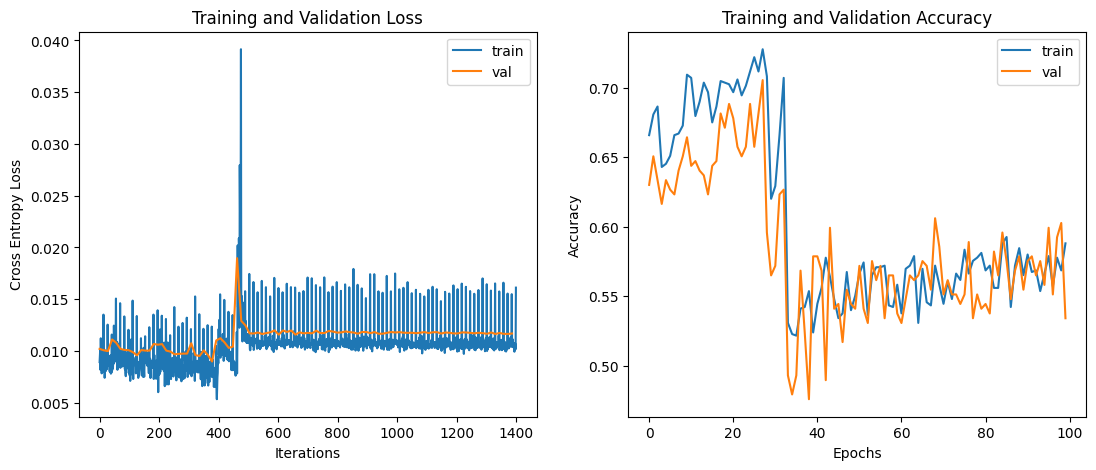

In [29]:
plot_eval(100,train_loader,train_loss,val_loss,train_accuracy, val_accuracy)

In [30]:
path = project_root + 'best_basicLSTM.pth'

state_dict = torch.load(path)
print(f"Best validation epoch loss obtained in Basic LSTM: {state_dict['e_loss']:.4f}")

Best validation epoch loss obtained in Basic LSTM: 0.0090


C:\Users\DELL\AppData\Local\Temp\ipykernel_16728\1878021502.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


In [31]:
model_lstm_1 = LSTM(input_size=3, hidden_size=64, num_layers=1, output_size=2).float()
state_dict = torch.load(path)
model_lstm_1.load_state_dict(state_dict['model_state_dict'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_16728\583815839.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


<All keys matched successfully>

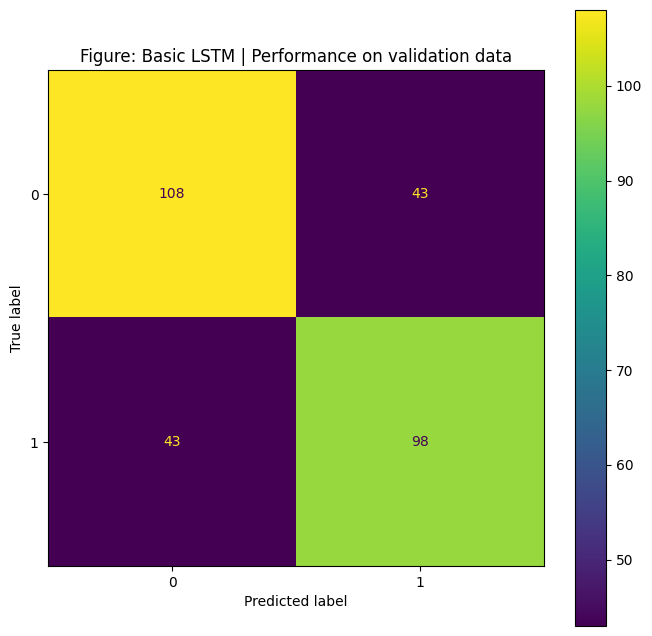

Loss: 0.5243, Accuracy: 70.55%


(0.5242542505264283, 70.54794520547945)

In [32]:
test_model(model_lstm_1, val_loader, loss_func, 'Figure: Basic LSTM | Performance on validation data')

In [33]:
def calculate_class_weights(data_loader, num_classes):
    class_counts = [0] * num_classes

    # Count the occurrences of each class in the dataset
    for _, labels in data_loader:
        for label in labels.numpy():
            class_counts[label] += 1
    # Calculate class weights using a formula that adjusts for imbalance
    total_samples = sum(class_counts)
    class_weights = [total_samples / (num_classes * count) for count in class_counts]
    return class_weights

def loss_func_weighted(class_weights, logits,y):
  return nn.CrossEntropyLoss(weight=class_weights)(logits, y)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.FloatTensor(calculate_class_weights(train_loader, 2))
class_weights = class_weights.to(device)

In [35]:
%%time
basic_lstm_2 = LSTM(input_size=3, hidden_size=64, num_layers=1, output_size=2).float()
optimizer = torch.optim.Adam(basic_lstm_2.parameters(), lr=0.01,)
save_path = project_root + 'best_basicLSTM_weightedloss.pth'
loss_func_weighted = nn.CrossEntropyLoss(weight=class_weights)
# perform training, save the model at the best epoch val_loss
train_loss,train_accuracy, val_loss, val_accuracy=train_and_validate(basic_lstm_2,optimizer, loss_func_weighted,
                                                                     train_loader, val_loader , save_path, epochs=60)

Epoch 1/60, Epoch validation loss: 0.0119, Train acc.: 0.5000, Validation acc.: 0.4795
Epoch 2/60, Epoch validation loss: 0.0118, Train acc.: 0.5126, Validation acc.: 0.5685
Epoch 3/60, Epoch validation loss: 0.0118, Train acc.: 0.5732, Validation acc.: 0.5411
Epoch 4/60, Epoch validation loss: 0.0117, Train acc.: 0.5355, Validation acc.: 0.5753
Epoch 5/60, Epoch validation loss: 0.0116, Train acc.: 0.5778, Validation acc.: 0.5822
Epoch 6/60, Epoch validation loss: 0.0116, Train acc.: 0.5755, Validation acc.: 0.5651
Epoch 7/60, Epoch validation loss: 0.0116, Train acc.: 0.5904, Validation acc.: 0.5685
Epoch 8/60, Epoch validation loss: 0.0115, Train acc.: 0.5847, Validation acc.: 0.5856
Epoch 9/60, Epoch validation loss: 0.0117, Train acc.: 0.5778, Validation acc.: 0.5548
Epoch 10/60, Epoch validation loss: 0.0114, Train acc.: 0.5927, Validation acc.: 0.5685
Epoch 11/60, Epoch validation loss: 0.0113, Train acc.: 0.5870, Validation acc.: 0.5993
Epoch 12/60, Epoch validation loss: 0.011

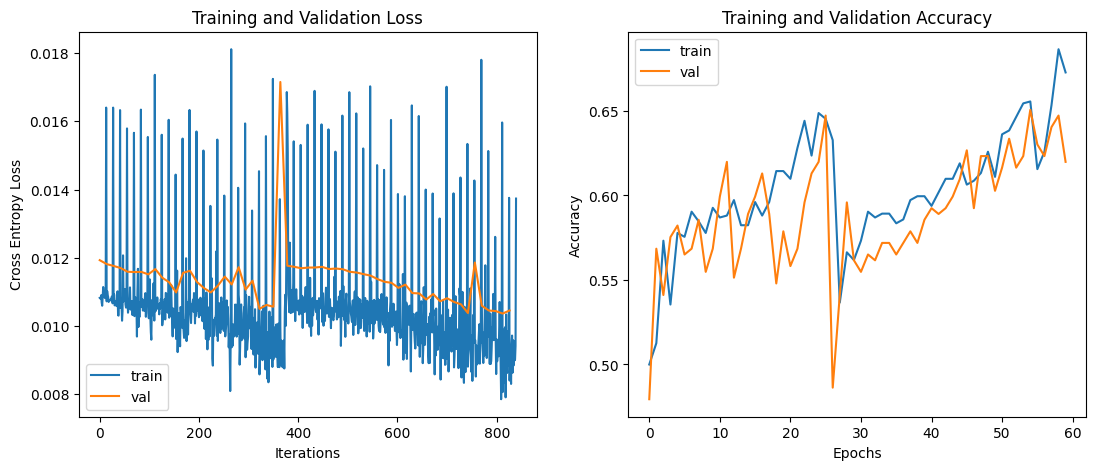

In [36]:
plot_eval(60, train_loader, train_loss, val_loss, train_accuracy, val_accuracy)

In [37]:
# reconstruct path of the best trial
path = project_root + 'best_basicLSTM_weightedloss.pth'

state_dict = torch.load(path)
print(f"Best validation epoch loss obtained in Basic LSTM with weighted loss: {state_dict['e_loss']:.4f}")

Best validation epoch loss obtained in Basic LSTM with weighted loss: 0.0104


C:\Users\DELL\AppData\Local\Temp\ipykernel_16728\2949944440.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


In [38]:
model_lstm_2 = LSTM(input_size=3, hidden_size=64, num_layers=1, output_size=2)
state_dict = torch.load(path)
model_lstm_2.load_state_dict(state_dict['model_state_dict'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_16728\4133128821.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


<All keys matched successfully>

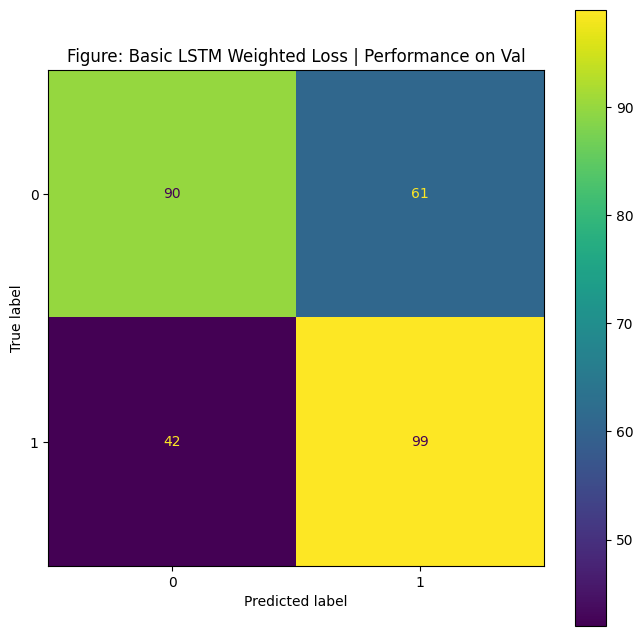

Loss: 0.6054, Accuracy: 64.73%


(0.6054090619087219, 64.72602739726028)

In [39]:
test_model(model_lstm_2,val_loader, loss_func, 'Figure: Basic LSTM Weighted Loss | Performance on Val')

In [40]:
def mod_train_and_validate(model, optimizer, loss_func, train_loader, val_loader, save_path, epochs=40, patience= 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss = []       # where we keep track of the training loss
    train_accuracy = []   # where we keep track of the training accuracy of the model
    val_loss = []         # where we keep track of the validation loss
    val_accuracy = []     # where we keep track of the validation accuracy of the model

    model.to(device)
    min_val_loss = np.Inf
    counter = 0
    delta_p = 0 #-- minimum change required in the monitored quantity (e.g. validation loss) to qualify as an improvement


    for e in range(epochs):
        epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, val_loader, device)

        train_loss.extend(epoch_train_loss)
        train_accuracy.append(epoch_train_accuracy)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)
        print(f'Epoch {e + 1}/{epochs}, Epoch validation loss: {epoch_val_loss:.4f}, Train acc: {epoch_train_accuracy:.4f}, Validation acc: {epoch_val_accuracy:.4f}')
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'e_loss': epoch_val_loss,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss':val_loss,
                'val_accuracy':val_accuracy
            }, save_path)
        elif epoch_val_loss-min_val_loss > delta_p:
          counter = counter + 1
        if counter == patience:
          break

    print('Training finished.')
    return train_loss, train_accuracy, val_loss, val_accuracy, e

In [41]:
def objective4(trial):
    params = {
        'input_size':3,
        'output_size': 2,
        'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
        'hidden_size': trial.suggest_categorical('num_hidden_units', [32,64,128,256])
        }
    trial_number = trial.number
    # define the model with the given parameters, make predictions
    model = LSTM(**params)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # create a new path for saving the best epoch model for each trial
    # since we do not know in advance which trial will the best, we will have to save all
    # and then read the best epoch of the best trial at the end
    save_path = project_root + f'trial_{trial_number}' + 'best_ModLSTM.pth'
    train_loss,train_accuracy, val_loss, val_accuracy,e=mod_train_and_validate(model,optimizer, loss_func,
                                                                             train_loader, val_loader,save_path=save_path,
                                                                             epochs=60)
    return val_loss[-1]

In [ ]:
%%time
sampler = TPESampler(seed=123)

#create a study, determine whether the objective function will be minimized or maximized using 'direction' parameter
study5= optuna.create_study(direction='minimize', sampler=sampler)
study5.optimize(objective4, n_trials=20)

[I 2024-11-12 16:19:11,390] A new study created in memory with name: no-name-0d47e5bc-6040-4301-95c3-e8377631af66


Epoch 1/60, Epoch validation loss: 0.0120, Train acc: 0.5172, Validation acc: 0.4829
Epoch 2/60, Epoch validation loss: 0.0118, Train acc: 0.5263, Validation acc: 0.5685
Epoch 3/60, Epoch validation loss: 0.0118, Train acc: 0.5847, Validation acc: 0.5651
Epoch 4/60, Epoch validation loss: 0.0117, Train acc: 0.5297, Validation acc: 0.5685
Epoch 5/60, Epoch validation loss: 0.0117, Train acc: 0.5881, Validation acc: 0.5616
Epoch 6/60, Epoch validation loss: 0.0117, Train acc: 0.5458, Validation acc: 0.5479
Epoch 7/60, Epoch validation loss: 0.0116, Train acc: 0.5423, Validation acc: 0.5685
Epoch 8/60, Epoch validation loss: 0.0116, Train acc: 0.5732, Validation acc: 0.5685
Epoch 9/60, Epoch validation loss: 0.0114, Train acc: 0.5778, Validation acc: 0.5514
Epoch 10/60, Epoch validation loss: 0.0112, Train acc: 0.5778, Validation acc: 0.5788
Epoch 11/60, Epoch validation loss: 0.0113, Train acc: 0.5938, Validation acc: 0.5993
Epoch 12/60, Epoch validation loss: 0.0118, Train acc: 0.5481, 

[I 2024-11-12 16:24:57,835] Trial 0 finished with value: 0.012497817816799634 and parameters: {'num_layers': 1, 'num_hidden_units': 128}. Best is trial 0 with value: 0.012497817816799634.


Epoch 14/60, Epoch validation loss: 0.0125, Train acc: 0.4668, Validation acc: 0.4897
Training finished.


In [2]:
import optuna


def objective(trial):
    x = trial.suggest_float("x", -100, 100)
    y = trial.suggest_int("y", -100, 100)
    return x**2 + y**2


search_space = {"x": [-50, 0, 50], "y": [-99, 0, 99]}
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective)

[I 2024-11-13 23:27:05,119] A new study created in memory with name: no-name-b48cb49c-5fd8-4b81-90e7-2aa305d19046
[I 2024-11-13 23:27:05,121] Trial 0 finished with value: 2500.0 and parameters: {'x': 50.0, 'y': 0}. Best is trial 0 with value: 2500.0.
[I 2024-11-13 23:27:05,123] Trial 1 finished with value: 12301.0 and parameters: {'x': -50.0, 'y': 99}. Best is trial 0 with value: 2500.0.
[I 2024-11-13 23:27:05,127] Trial 2 finished with value: 2500.0 and parameters: {'x': -50.0, 'y': 0}. Best is trial 0 with value: 2500.0.
[I 2024-11-13 23:27:05,129] Trial 3 finished with value: 0.0 and parameters: {'x': 0.0, 'y': 0}. Best is trial 3 with value: 0.0.
[I 2024-11-13 23:27:05,132] Trial 4 finished with value: 12301.0 and parameters: {'x': 50.0, 'y': 99}. Best is trial 3 with value: 0.0.
[I 2024-11-13 23:27:05,135] Trial 5 finished with value: 12301.0 and parameters: {'x': 50.0, 'y': -99}. Best is trial 3 with value: 0.0.
[I 2024-11-13 23:27:05,137] Trial 6 finished with value: 9801.0 and 